#### Set Up

In [1]:
import re
import string

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import sent_tokenize

In [2]:
input_path = "../data/uit_dsc_25/vihallu-train.csv"
output_path = "../data/uit_dsc_25/vihallu-train-filtered.csv"

#### Trainning Set Filtering

In [3]:
train = pd.read_csv(input_path)
print(f"Length of train: {len(train)}")
train.head()

Length of train: 7000


,id,context,prompt,response,label
0,9b1ea51d-d1ff-45ba-8cf1-6a91328e8600,"Vào những năm 1870, hai nhà điêu khắc Augustus...","Vào những năm 1960, nơi nào trở thành trung tâ...",Quảng trường Washington là trung tâm của thế h...,extrinsic
1,db7a89c6-2a6a-42af-beef-58e557ecc819,Cách mạng Tháng Mười đã biến một cuộc chiến tr...,Cách mạng Tháng Mười đã khởi xướng chủ nghĩa p...,Sai. Cách mạng Tháng Mười đã đánh bại chủ nghĩ...,no
2,10fca062-d343-4eca-8434-93c7a8aa5e0e,Vị trí địa lý nằm giữa phương Đông và Địa Trun...,Dựa trên việc Đế quốc Ottoman không bao giờ ki...,Nền ẩm thực của Thổ Nhĩ Kỳ được xây dựng từ gi...,extrinsic
3,ece8eb9e-d6bb-407a-a567-d9531861c603,"Hồ Quý Ly trước có tên là Lê Quý Ly (黎季犛), biể...",Đời cháu thứ 12 của Hồ Hưng Dật sống ở đâu?,"Đời cháu thứ 12 của Hồ Hưng Dật, là Hồ Liêm, s...",no
4,b613217f-df2a-491e-8326-25811a31eb09,"Năm 2007, Bồ Đào Nha có khoảng 332.137 người n...","Từ thập niên 1990, tại sao xuất hiện một vài l...",Mặc dù Bồ Đào Nha đã đóng cửa biên giới hoàn t...,intrinsic


In [4]:
train = train[train["response"].str.endswith(tuple(string.punctuation))]
print(f"Length of train without cutoff responses: {len(train)}")
train.head()

Length of train without cutoff responses: 6734


,id,context,prompt,response,label
1,db7a89c6-2a6a-42af-beef-58e557ecc819,Cách mạng Tháng Mười đã biến một cuộc chiến tr...,Cách mạng Tháng Mười đã khởi xướng chủ nghĩa p...,Sai. Cách mạng Tháng Mười đã đánh bại chủ nghĩ...,no
2,10fca062-d343-4eca-8434-93c7a8aa5e0e,Vị trí địa lý nằm giữa phương Đông và Địa Trun...,Dựa trên việc Đế quốc Ottoman không bao giờ ki...,Nền ẩm thực của Thổ Nhĩ Kỳ được xây dựng từ gi...,extrinsic
3,ece8eb9e-d6bb-407a-a567-d9531861c603,"Hồ Quý Ly trước có tên là Lê Quý Ly (黎季犛), biể...",Đời cháu thứ 12 của Hồ Hưng Dật sống ở đâu?,"Đời cháu thứ 12 của Hồ Hưng Dật, là Hồ Liêm, s...",no
4,b613217f-df2a-491e-8326-25811a31eb09,"Năm 2007, Bồ Đào Nha có khoảng 332.137 người n...","Từ thập niên 1990, tại sao xuất hiện một vài l...",Mặc dù Bồ Đào Nha đã đóng cửa biên giới hoàn t...,intrinsic
5,4a3e2996-af6a-430b-a5f3-c920e84bae5b,Thủy triều cao và sự hiện hữu của một lực lượn...,Địa điểm tiến công của quân đoàn X trong Chiến...,Địa điểm tiến công của Quân đoàn X trong Chiến...,no


In [5]:
train.to_csv(output_path)

#### Traning Set Analysis

In [6]:
print("Distribution of label:\n", train['label'].value_counts().reset_index())

Distribution of label:
        label  count
0  intrinsic   2402
1         no   2212
2  extrinsic   2120


In [7]:
train['prompt_len'] = train['prompt'].astype(str).apply(len)
train['response_len'] = train['response'].astype(str).apply(len)
train['context_len'] = train['context'].astype(str).apply(len)
print("Mean lengths of input by label:\n", train.groupby('label')[['context_len', 'prompt_len', 'response_len']].mean().reset_index())

Mean lengths of input by label:
        label  context_len  prompt_len  response_len
0  extrinsic   814.893868  116.950943    206.373113
1  intrinsic   838.842215  123.011241    178.544963
2         no   830.109855  119.559675    150.488246


In [8]:
def sentences_count(passage, min_len=10):
    result = []
    sentences = [sent.strip() for sent in sent_tokenize(passage)]

    # Edge case: first sentence is a short one
    if sentences and len(sentences[0]) < min_len and len(sentences) > 1:
        sentences[1] = sentences[0] + ' ' + sentences[1]
        sentences = sentences[1:]

    # Concat short sentence to the previous one
    for s in sentences:
        if result and len(s) < min_len:
            result[-1] = result[-1] + ' ' + s
        else:
            result.append(s)
    return len(result)

In [9]:
train['response_sentence_count'] = train['response'].apply(sentences_count)
frequency_table = train['response_sentence_count'].value_counts().sort_index()
frequency_table

response_sentence_count
1    4725
2    1919
3      89
4       1
Name: count, dtype: int64

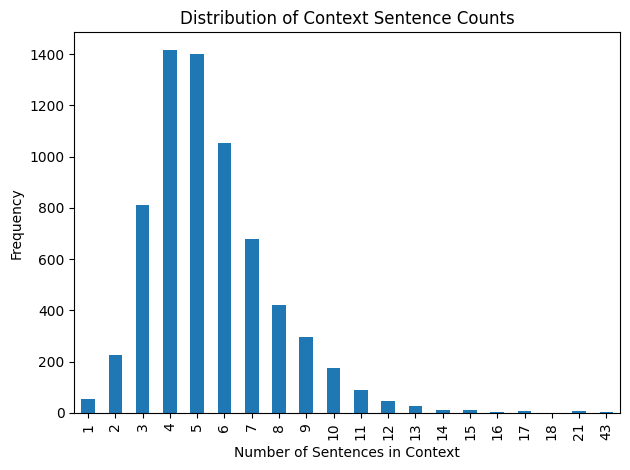

In [10]:
train['context_sentence_count'] = train['context'].apply(sentences_count)
frequency_table = train['context_sentence_count'].value_counts().sort_index()

frequency_table.plot(kind='bar')
plt.xlabel('Number of Sentences in Context')
plt.ylabel('Frequency')
plt.title('Distribution of Context Sentence Counts')
plt.tight_layout()
plt.show()